In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1061 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.13s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


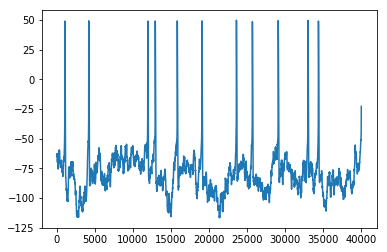

In [7]:
voltage1 = mon.v[0]/mV
plot(voltage1);

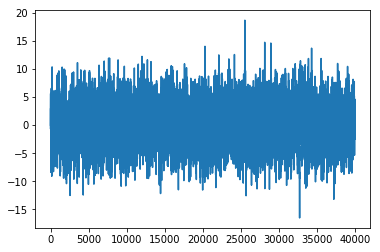

In [8]:
inp_cur1 = mon.I[0]/nA
plot(inp_cur1);

In [9]:
out_spikes1 = [spike_mon.spike_trains()[0]/ms]
out_spikes1

[array([ 10.26,  41.66, 119.22, 129.06, 157.96, 190.4 , 235.7 , 256.68,
        290.66, 329.77, 343.48, 399.91])]

In [10]:
start_scope()
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


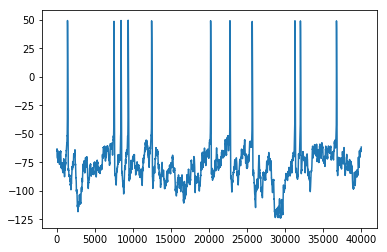

In [11]:
voltage2 = mon.v[0]/mV
plot(voltage2);

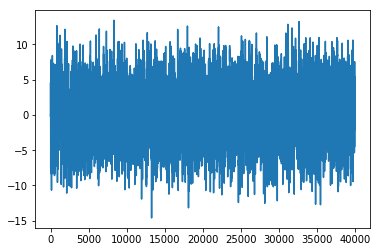

In [12]:
inp_cur2 = mon.I[0]/nA
plot(inp_cur2);

In [13]:
out_spikes2 = [spike_mon.spike_trains()[0]/ms]
out_spikes2

[array([ 13.71,  74.8 ,  84.03,  93.45, 124.26, 201.8 , 227.21, 256.44,
        312.6 , 319.81, 367.19])]

In [14]:
out_spikes1

[array([ 10.26,  41.66, 119.22, 129.06, 157.96, 190.4 , 235.7 , 256.68,
        290.66, 329.77, 343.48, 399.91])]

In [15]:
out_spikes = [out_spikes1[0], out_spikes2[0]]
out_spikes

[array([ 10.26,  41.66, 119.22, 129.06, 157.96, 190.4 , 235.7 , 256.68,
        290.66, 329.77, 343.48, 399.91]),
 array([ 13.71,  74.8 ,  84.03,  93.45, 124.26, 201.8 , 227.21, 256.44,
        312.6 , 319.81, 367.19])]

In [16]:
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        ,  1.11428648,  2.85746132, ..., -1.95912002,
        -1.35416904, -0.32246148]),
 array([0.        , 2.2097749 , 2.52872291, ..., 3.23139285, 4.90646393,
        5.21015284])]

## Model Fitting

In [17]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau :volt
        dvt/dt = (a*v - vt) / taut :volt
        alpha : volt (constant)
        a : 1 (constant)
        R : ohm (constant)
        tau : second (constant)
        taut : second (constant)
        '''
reset = '''
v = 0*mV
vt = vt + alpha
'''

In [18]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=30*ms)

In [19]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=30,
                     threshold='v > vt',
                     reset=reset,
                     refractory=1.4*ms,
                     param_init={'v': -65*mV},
                     )

In [20]:
result_dict, error = fitter.fit(n_rounds=40,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[5, 15]*mV,
                                a = [0.1, 2],
                                R = [0.1, 100]*Mohm, 
                                tau = [7, 15]*ms,
                                taut = [80, 110]*ms,
                               )

WARNING    "tau" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Round 0: fit (0.08677779731878124, 0.007505929067532955, 0.009292007747077734, 1.5530152895818654, 79938447.36871687) with error: 0.1186615186615183
Round 1: fit (0.08649608127591449, 0.006891455558839441, 0.009509133919502118, 1.301875387903613, 86647993.91788179) with error: 0.08181167203723572
Round 2: fit (0.08377653989841741, 0.008044787202029339, 0.008046985139432458, 1.301875387903613, 86647993.91788179) with error: 0.0210281802066139
Round 3: fit (0.086293971517876, 0.006471618882057764, 0.008079629492497603, 0.6490031826950249, 87794449.6167154) with error: 0.011817653890824342
Round 4: fit (0.08464802181660748, 0.006471618882057764, 0.008079629492497603, 0.6490031826950249, 86289011.38817532) with error: 0.011817653890824342
Round 5: fit (0.08303909280402369, 0.007815873312219878, 0.007403465791163492, 0.7346561869095962, 91330529.0741187) with error: 0.011817653890824342
Round 6: fit (0.08390900723395213, 0.005779825024781912, 0.007577282639713953, 0.26288676628700713, 78914

In [21]:
result_dict

{'taut': 0.0826813173592604,
 'alpha': 0.006185452509087443,
 'tau': 0.007968003927344244,
 'a': 0.4841638386631273,
 'R': 85278827.20736471}

In [22]:
error

0.011817653890824342

In [23]:
1 - error

0.9881823461091757

In [24]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

WARNING    "tau" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


spike times: [array([  9.73,  11.13,  15.18,  16.82,  39.79,  41.19,  44.79,  55.19,
        76.87, 115.28, 119.52, 120.92, 127.33, 153.43, 156.95, 189.45,
       226.09, 234.7 , 236.1 , 255.38, 283.34, 287.17, 295.01, 328.63,
       330.03, 332.33, 343.04, 391.43, 399.  ]), array([ 12.23,  13.63,  15.03,  20.71,  35.52,  60.78,  73.53,  80.32,
        83.45,  84.85,  92.58,  93.98, 129.14, 179.96, 190.68, 200.52,
       202.27, 209.7 , 227.58, 246.52, 265.04, 307.37, 311.85, 317.24,
       319.19, 322.42, 366.73, 369.85, 398.97])]


In [25]:
print(len(out_spikes[0]))
print(len(spikes[0]))

12
29


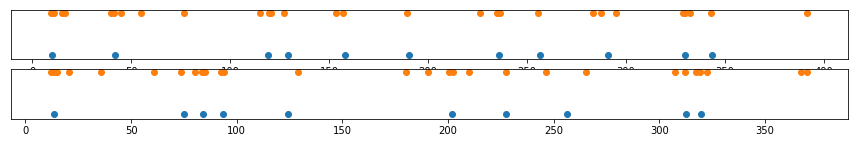

In [26]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [27]:
fits = fitter.generate(params=None, output_var='v',)

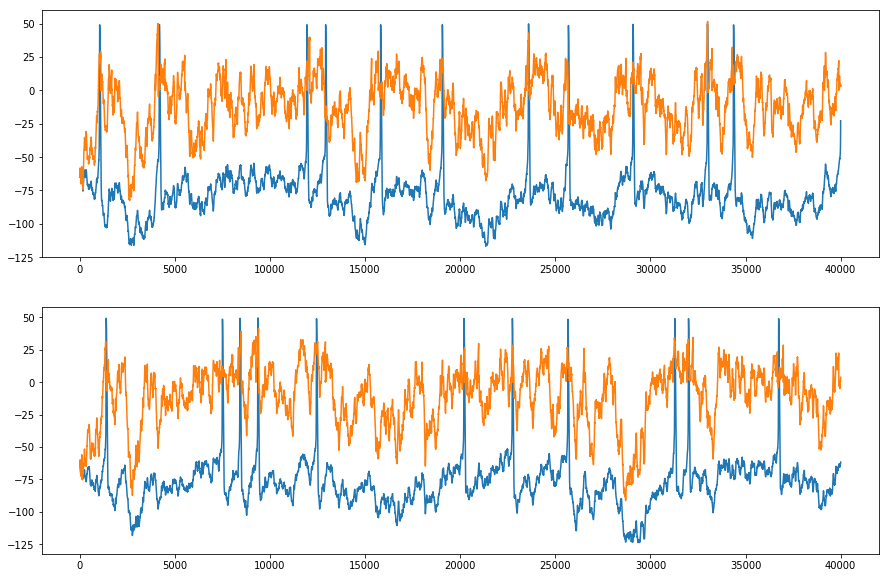

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))

ax[0].plot(voltage1);
ax[0].plot(fits[0]/mV)

ax[1].plot(voltage2);
ax[1].plot(fits[1]/mV);
